# Homework 4: Character-level prediction with RNNs

**By:** Oorjit Chowdhary

In this homework, you will train a recurrent neural network to predict the next English character, using a small corpus of works from Shakespeare. This notebook will walk you through the different steps required to accomplish this.

**Deliverable**: You should submit the completed version of this Jupyter notebook to Gradescope.

In [1]:
import random
import urllib.request
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

The function `load_shakespeare_corpus()` below downloads the corpus into a local text file, and reads the contents into a string variable called `text`.

In [2]:
# Part 1: load the tiny shakespeare corpus

def load_shakespeare_corpus():
  url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
  path = Path("tinyshakespeare.txt")

  # Download the file if it doesn't exist
  if not path.exists():
    print("Downloading tinyshakespeare.txt...")
    urllib.request.urlretrieve(url, path)
    print("Download complete.")
  else:
    print(f"{path} already exists.")

  # Read and process the text
  text = path.read_text(encoding="utf-8").lower()
  return text

text = load_shakespeare_corpus()

print(f"Data loaded. Vocabulary size: {len(set(text))}")

tinyshakespeare.txt already exists.
Data loaded. Vocabulary size: 39


Below, we create a `Vocab` class that stores all distinct tokens (characters and some minimal punctuation) encountered in the corpus and creates a token-to-integer mapping. We will use that mapping later to convert text to numerical inputs for the RNN that we will train.

In [3]:
import re
from collections import Counter
from typing import List

def isolate_chars_and_punctuation(text: str) -> str:
    """Isolate characters and punctuation."""
    return re.sub("[^A-Za-z']+", " ", text).lower()


def tokenize(text: str) -> List[str]:
    """Turn text into a Python list of tokens."""
    return list(isolate_chars_and_punctuation(text))


class Vocab(object):
    """Vocabulary for text.

    Taken from Dive into Deep Learning: https://d2l.ai/chapter_recurrent-neural-networks/text-sequence.html
    """

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(
            sorted(
                set(
                    ["<unk>"]
                    + reserved_tokens
                    + [token for token, freq in self.token_freqs if freq >= min_freq]
                )
            )
        )
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, "__len__") and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx["<unk>"]

In [4]:
# Create a vocabulary based on the current text.
vocab = Vocab(tokenize(text))

# The vocabulary will ignore punctuation other than spaces and "'".
vocab.token_to_idx

{' ': 0,
 "'": 1,
 '<unk>': 2,
 'a': 3,
 'b': 4,
 'c': 5,
 'd': 6,
 'e': 7,
 'f': 8,
 'g': 9,
 'h': 10,
 'i': 11,
 'j': 12,
 'k': 13,
 'l': 14,
 'm': 15,
 'n': 16,
 'o': 17,
 'p': 18,
 'q': 19,
 'r': 20,
 's': 21,
 't': 22,
 'u': 23,
 'v': 24,
 'w': 25,
 'x': 26,
 'y': 27,
 'z': 28}

The example below shows how to use the `vocab` object to convert a string of characters to integers.

In [5]:
example_string = "the quick fox"

# tokenize first
example_tokens = tokenize(example_string)

# apply the vocab to the tokenized version.
# NOTE: we use slicing notation instead of parentheses.
vocab[example_tokens]

[22, 10, 7, 0, 19, 23, 11, 5, 13, 0, 8, 17, 26]

In [6]:
# Inspect the Data
print(f"Total characters in the dataset: {len(text)}")
print(f"Unique characters (vocab size): {len(vocab)}")
print("\n--- Data Snippet (first 80 chars) ---")
print(text[:80])
print("----------------------------------------")

Total characters in the dataset: 1115394
Unique characters (vocab size): 29

--- Data Snippet (first 80 chars) ---
first citizen:
before we proceed any further, hear me speak.

all:
speak, speak.
----------------------------------------


In the cell below, we create hyperparameters used throughout our model definition and training. These include the size of the hidden state maintained by the RNN, the number of training epochs and learning rate, the length of input sequences and predictions, and the number of steps per epoch.

In [7]:
# 2. Hyperparameters
hidden_size = 64
learning_rate = 0.005
num_epochs = 100
sequence_length = 32
steps_per_epoch = 128

## Part 1: creating the dataset

Below, we will create a character prediction dataset. To do so, we will create a subclass of the `torch.utils.data.Dataset` class whose `__getitem__` method provides pairs of text sequences of equal length which are one character apart in the original corpus.

To demonstrate, suppose that the corpus is a single sentence:

```
the quick brown fox jumps over the lazy dog
```

and suppose that we set `seq_len = 3` in the constructor of `CharPredictionDataset`. Then, calling the `__getitem__` method with argument `index=4` should access the following pair of character sequences:

```
("qui", "uic")
```

and map them to the corresponding one-hot encoding, as provided by the `to_one_hot_sequence` function below.

In [8]:
# Create the tensor dataset
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.functional import one_hot


# One-hot encoding function
def to_one_hot_sequence(indices: List[int], vocab: Vocab) -> torch.Tensor:
    """Converts a list of indices into a one-hot tensor.

    Args:
        indices (List[int]): List of indices.
        vocab (Vocab): A vocabulary object.
    """
    # Convert indices to tensors and perform One-Hot encoding.
    indices_tensor = torch.tensor(indices, dtype=torch.long)
    return one_hot(indices_tensor, num_classes=len(vocab)).float()


class CharPredictionDataset(Dataset):
    """Custom dataset for character prediction.

    Attributes:
      data: The corpus text.
      seq_len: The length of each sequence in the dataset.
      vocab: A vocabulary object providing the token-to-integer mapping.
    """
    def __init__(self, data: str, seq_len: int, vocab: Vocab):
      self.text = data
      self.seq_len = seq_len
      self.vocab = vocab

    def __len__(self):
      # Calculate the effective length of the dataset
      # We need seq_len characters for input and seq_len characters for output
      # So we need at least seq_len + seq_len characters, but output starts at index 1
      return len(self.text) - self.seq_len

    def __getitem__(self, index):
      # Construct the input and target sequences
      # 1. Determine the start and end positions of the slice
      start = index
      end = index + self.seq_len
      
      # Input sequence: characters from start to end
      input_text = self.text[start:end]
      # Target sequence: characters from start+1 to end+1 (shifted by 1)
      target_text = self.text[start + 1:end + 1]
      
      # 2. Process the text using the tokenize function
      input_tokens = tokenize(input_text)
      target_tokens = tokenize(target_text)
      
      # 3. Convert the tokens to indices using vocab
      input_indices = self.vocab[input_tokens]
      target_indices = self.vocab[target_tokens]
      
      # 4. Convert to tensors using to_one_hot_sequence
      input_seq = to_one_hot_sequence(input_indices, self.vocab)
      target_seq = to_one_hot_sequence(target_indices, self.vocab)
      
      return input_seq, target_seq


dataset = CharPredictionDataset(isolate_chars_and_punctuation(text), seq_len=sequence_length, vocab=vocab)

In [9]:
test_corpus = "the quick brown fox jumps over the lazy dog"
test_vocab = Vocab(tokenize(test_corpus))
test_dataset = CharPredictionDataset(isolate_chars_and_punctuation(test_corpus), seq_len=3, vocab=test_vocab)

print(f"Test dataset length: {len(test_dataset)}")
input_seq, target_seq = test_dataset[4]
print(f"Input sequence shape: {input_seq.shape}")
print(f"Target sequence shape: {target_seq.shape}")

input_indices = torch.argmax(input_seq, dim=1).tolist()
target_indices = torch.argmax(target_seq, dim=1).tolist()

input_chars = test_vocab.to_tokens(input_indices)
target_chars = test_vocab.to_tokens(target_indices)

print(f"Input characters: {''.join(input_chars)}")
print(f"Target characters: {''.join(target_chars)}")

Test dataset length: 40
Input sequence shape: torch.Size([3, 28])
Target sequence shape: torch.Size([3, 28])
Input characters: qui
Target characters: uic


## Part 2: creating the model

Below, we define the character-level RNN model. Your task is to complete the missing neural network blocks (the fields currently set as `None` in the constructor) and the `forward` method, according to the following specification:

- the `rnn` block should be a RNN block expecting inputs of size `input_size`, maintaining a hidden state of size `hidden_size`.
- the `fc` block should be a fully connected linear layer mapping inputs of size `hidden_size` to outputs of size `vocab_size`.
- the `softmax` block should apply the softmax function to the last dimension of the output of the fully connected linear layer.

**Note**: your `.forward()` method implementation should expect inputs of size $(N, L, V)$, where $N$ is the batch size, $L$ is the sequence length, and $S$ is the dimension of the one-hot encoding (equal to the size of the vocabulary), and return outputs of the same size.

In [10]:
# 3. Model Definition
class CharRNN(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, vocab_size: int):
        super(CharRNN, self).__init__()
        self.hidden_size = hidden_size
        # Complete the definitions below
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_size)
        # hidden shape: (batch_size, 1, hidden_size)

        # Forward Propagation

        # 1. Pass x into the RNN layer
        # Note: The RNN returns two values: (output, hidden), we only need the output
        rnn_out, _ = self.rnn(x)
        
        # 2. Pass the RNN output into the fully connected layer
        # rnn_out shape: (batch_size, seq_len, hidden_size)
        fc_out = self.fc(rnn_out)
        
        # 3. Apply Softmax to the result and return
        # fc_out shape: (batch_size, seq_len, vocab_size)
        output = self.softmax(fc_out)
        return output

Below, we create the RNN model and use the Adam optimizer (a variant of stochastic gradient descent) to minimize the cross-entropy loss.

In [11]:
# Accelerate training using GPU if available
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

print(f"Device: {device}")

# 4. Initialize Model, Loss, and Optimizer
model = CharRNN(len(vocab), hidden_size, len(vocab)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

print(model)

Using MPS (Apple Silicon GPU)
Device: mps
CharRNN(
  (rnn): RNN(29, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=29, bias=True)
  (softmax): Softmax(dim=-1)
)


In [12]:
text_loader = DataLoader(dataset, batch_size=1024, shuffle=True, drop_last=True)

inp, outp = next(iter(text_loader))
inp.shape

torch.Size([1024, 32, 29])

## Part 3: training loop

Complete the training loop below, using the model and dataloader defined in the previous cells.

In [13]:
from tqdm import tqdm
import numpy as np

# 6. Training Loop
print("Starting training...")
all_losses = []  # To store average loss per epoch

for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0.0
    
    # Load a minibatch from dataloader
    for input_seq, target_seq in text_loader:
        # Move data to device (MPS/GPU)
        input_seq = input_seq.to(device)
        target_seq = target_seq.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(input_seq)
        
        # Convert target from one-hot to class indices
        target_indices = torch.argmax(target_seq, dim=-1)
        
        # Reshape output: (batch_size * seq_len, vocab_size)
        output_flat = output.view(-1, len(vocab))
        # Reshape target: (batch_size * seq_len)
        target_flat = target_indices.view(-1)
        
        # Calculate loss
        loss = criterion(output_flat, target_flat)
        
        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        # Accumulate loss
        epoch_loss += loss.item()
    
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(text_loader)
    all_losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"\nEpoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

print("Training complete!")

Starting training...


 10%|█         | 10/100 [09:16<1:24:01, 56.02s/it]


Epoch [10/100], Average Loss: 2.9849


 20%|██        | 20/100 [18:37<1:14:32, 55.90s/it]


Epoch [20/100], Average Loss: 2.9779


 30%|███       | 30/100 [27:46<1:03:42, 54.61s/it]


Epoch [30/100], Average Loss: 2.9744


 40%|████      | 40/100 [36:56<53:56, 53.95s/it]  


Epoch [40/100], Average Loss: 2.9679


 50%|█████     | 50/100 [46:11<46:32, 55.86s/it]


Epoch [50/100], Average Loss: 2.9658


 60%|██████    | 60/100 [55:33<37:24, 56.10s/it]


Epoch [60/100], Average Loss: 2.9647


 70%|███████   | 70/100 [1:04:02<25:16, 50.55s/it]


Epoch [70/100], Average Loss: 2.9637


 80%|████████  | 80/100 [1:12:28<16:42, 50.10s/it]


Epoch [80/100], Average Loss: 2.9624


 90%|█████████ | 90/100 [1:21:02<08:37, 51.76s/it]


Epoch [90/100], Average Loss: 2.9612


100%|██████████| 100/100 [1:29:39<00:00, 53.80s/it]


Epoch [100/100], Average Loss: 2.9606
Training complete!


## Part 4: plotting perplexity per epoch

In Lecture 13, we defined perplexity as the exponential of the average cross-entropy loss. Plot the perplexity by epoch below.

**Note**: recall that the cross-entropy losses calculated during training are stored in `all_losses`.

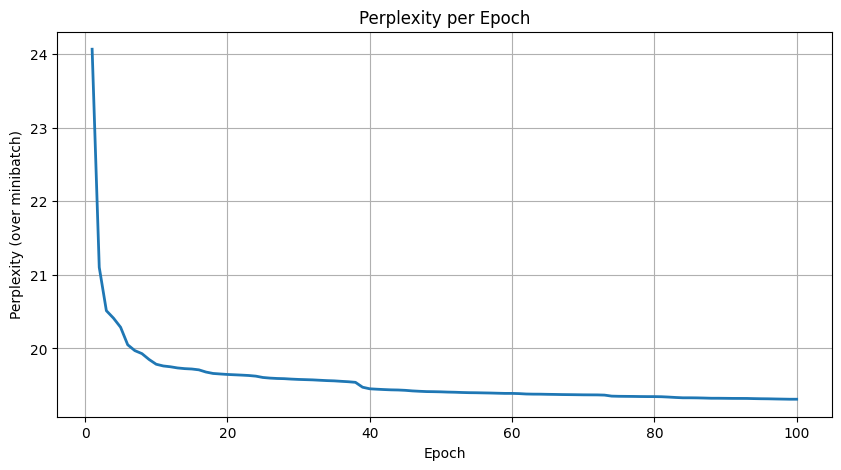

In [17]:
# 7. Calculate the perplexity and plot
plt.figure(figsize=(10, 5))

# Calculate perplexity from losses (perplexity = exp(loss))
perplexities = [np.exp(loss) for loss in all_losses]

# Plot perplexity over epochs
plt.plot(range(1, num_epochs + 1), perplexities, linewidth=2)

plt.title("Perplexity per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Perplexity (over minibatch)")
plt.grid(True)
plt.show()

Finally, in the last two cells we create a prediction function that predicts the next few characters given a partial sentence. You can run it to examine the predictions generated by the model.

In [15]:
# 6. Prediction Function
def predict_completion(prefix: str, max_new_chars: int = 32):
    """Generate text completions using the trained character-level RNN and vocabulary."""
    cleaned_prefix = isolate_chars_and_punctuation(prefix).strip().lower()
    if not cleaned_prefix:
        print("Error: Prefix cannot be empty after cleaning.")
        return

    print(f"Input: '{cleaned_prefix}'")

    tokens = tokenize(cleaned_prefix)
    if not tokens:
        print("Error: Prefix does not contain valid characters.")
        return

    unknown_chars = [ch for ch in tokens if ch not in vocab.token_to_idx]
    if unknown_chars:
        print(f"Warning: Unknown characters {set(unknown_chars)} will be mapped to <unk>.")

    indices = [vocab[token] for token in tokens]
    completion_tokens = tokens.copy()

    device = next(model.parameters()).device
    model.eval()

    def one_hot_batch(idx: int) -> torch.Tensor:
        return to_one_hot_sequence([idx], vocab).unsqueeze(0).float().to(device)

    with torch.no_grad():
        hidden = torch.zeros(1, 1, model.hidden_size, device=device)

        # Warm up hidden state with all but the last token of the prefix
        for idx in indices[:-1]:
            step_input = one_hot_batch(idx)
            _, hidden = model.rnn(step_input, hidden)

        current_idx = indices[-1]

        for _ in range(max_new_chars):
            step_input = one_hot_batch(current_idx)
            out, hidden = model.rnn(step_input, hidden)
            logits = model.fc(out)
            probs = torch.softmax(logits[:, -1, :], dim=-1)
            next_idx = torch.argmax(probs, dim=-1).item()
            next_token = vocab.idx_to_token[next_idx]

            completion_tokens.append(next_token)
            current_idx = next_idx

            if next_token in {" ", "\n"}:
                break

    prediction = "".join(completion_tokens)
    print(f"Prediction: {prediction}")

In [16]:
# 7. Run Predictions
predict_completion('appl')
print("-" * 20)
predict_completion('th')
print("-" * 20)
predict_completion('lov')
print("-" * 20)
predict_completion('ki')

Input: 'appl'
Prediction: apple 
--------------------
Input: 'th'
Prediction: the 
--------------------
Input: 'lov'
Prediction: love 
--------------------
Input: 'ki'
Prediction: kind 
